In [9]:
import pandas as pd
from dotenv import load_dotenv

from pydantic import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI

from api_helpers.clients import get_postgres_client


load_dotenv(
    dotenv_path="/Users/tomwattley/App/racing-api-project/racing-api-project/libraries/api-helpers/src/api_helpers/.env"
)

pg = get_postgres_client()

In [2]:
import numpy as np


def bootstrap_stat(x, n_boot=10000, stat="mean", seed=42, ci=(2.5, 97.5)):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]  # drop NaNs
    rng = np.random.default_rng(seed)
    n = x.size
    idx = rng.integers(0, n, size=(n_boot, n))  # bootstrap indices

    samples = x[idx]
    if stat == "mean":
        stats = samples.mean(axis=1)
    elif stat == "median":
        stats = np.median(samples, axis=1)
    else:
        # custom callable: stat(samples, axis=1)
        stats = stat(samples, axis=1)

    ci_vals = np.percentile(stats, ci) if ci else None
    return stats, ci_vals


# Example
data = [80.0, 89.0, 80.0, 63.0, 81.0, 64.0, np.nan, 60.0, 83.0, 72.0]
stats, ci = bootstrap_stat(data, n_boot=100000, stat="mean")
print(f"Bootstrap mean CI 95%: {ci}")

Bootstrap mean CI 95%: [68.22222222 80.88888889]


Original data: [80. 89. 80. 63. 81. 64. 60. 83. 72.]

One bootstrap sample: [80. 60. 64. 63. 63. 83. 80. 60. 89.]
Mean of this sample: 71.33

Random bootstrap sample #194: [72. 63. 83. 60. 72. 83. 64. 63. 64.]
Mean of this sample: 69.33

Original data has 9 unique values: [np.float64(60.0), np.float64(63.0), np.float64(64.0), np.float64(72.0), np.float64(80.0), np.float64(81.0), np.float64(83.0), np.float64(89.0)]
Bootstrap sample has these counts:
  60.0: appears 2 times
  63.0: appears 2 times
  64.0: appears 1 times
  80.0: appears 2 times
  83.0: appears 1 times
  89.0: appears 1 times


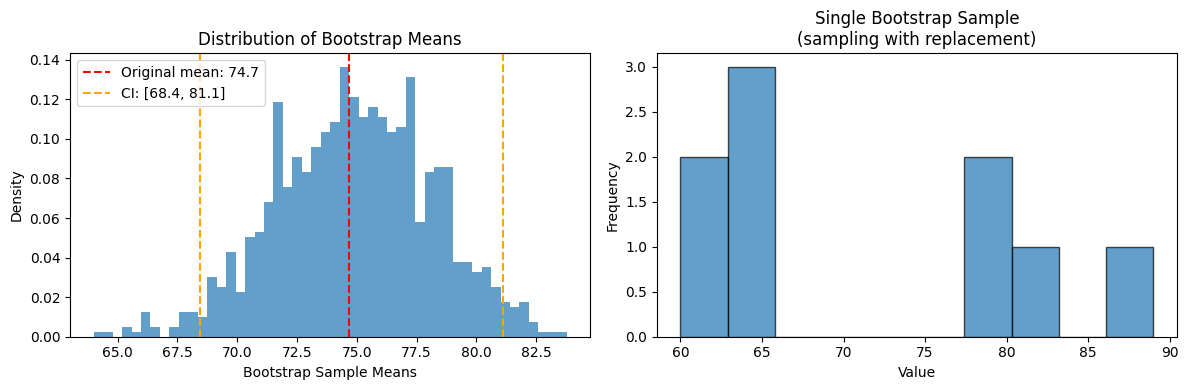


Bootstrap mean CI 95%: [68.44444444 81.11111111]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def bootstrap_stat(x, n_boot=10000, stat="mean", seed=42, ci=(2.5, 97.5)):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]  # drop NaNs
    rng = np.random.default_rng(seed)
    n = x.size
    idx = rng.integers(0, n, size=(n_boot, n))  # bootstrap indices

    samples = x[idx]
    if stat == "mean":
        stats = samples.mean(axis=1)
    elif stat == "median":
        stats = np.median(samples, axis=1)
    else:
        # custom callable: stat(samples, axis=1)
        stats = stat(samples, axis=1)

    ci_vals = np.percentile(stats, ci) if ci else None
    return stats, ci_vals, samples  # Return samples too


# Example
data = [80.0, 89.0, 80.0, 63.0, 81.0, 64.0, np.nan, 60.0, 83.0, 72.0]
clean_data = np.array(data)[~np.isnan(data)]  # Clean data for reference
print(f"Original data: {clean_data}")

# Get bootstrap statistics and samples
stats, ci, all_samples = bootstrap_stat(data, n_boot=1000, stat="mean")

# Draw one bootstrap sample (e.g., the first one)
single_sample = all_samples[0]
print(f"\nOne bootstrap sample: {single_sample}")
print(f"Mean of this sample: {single_sample.mean():.2f}")

# Or draw a random bootstrap sample
random_idx = np.random.randint(0, len(all_samples))
random_sample = all_samples[random_idx]
print(f"\nRandom bootstrap sample #{random_idx}: {random_sample}")
print(f"Mean of this sample: {random_sample.mean():.2f}")

# Show that it's sampling with replacement
print(f"\nOriginal data has {len(clean_data)} unique values: {sorted(set(clean_data))}")
print(f"Bootstrap sample has these counts:")
unique, counts = np.unique(single_sample, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  {val}: appears {count} times")

# Visualize the distribution of bootstrap means
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.hist(stats, bins=50, alpha=0.7, density=True)
# plt.axvline(np.mean(clean_data), color='red', linestyle='--', label=f'Original mean: {np.mean(clean_data):.1f}')
# plt.axvline(ci[0], color='orange', linestyle='--', label=f'CI: [{ci[0]:.1f}, {ci[1]:.1f}]')
# plt.axvline(ci[1], color='orange', linestyle='--')
# plt.xlabel('Bootstrap Sample Means')
# plt.ylabel('Density')
# plt.title('Distribution of Bootstrap Means')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.hist(single_sample, bins=10, alpha=0.7, edgecolor='black')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Single Bootstrap Sample\n(sampling with replacement)')
# plt.tight_layout()
# plt.show()

# print(f"\nBootstrap mean CI 95%: {ci}")

In [6]:
random_idx = np.random.randint(0, len(all_samples))
random_sample = all_samples[random_idx]

In [8]:
random_sample.mean()

np.float64(73.0)

In [33]:
race_id = 816785
one_y = pg.fetch_data(
    f"""                
							
                WITH todays_context AS (
                    SELECT 
                        pd.race_date AS todays_race_date
                    FROM public.unioned_results_data pd
                    WHERE pd.race_id = {race_id}
                    LIMIT 1
                ),
                -- Filter for last two years and apply other filters (equivalent to _filter_last_two_years)
                filtered_historical AS (
                    SELECT rd.*
                        FROM public.unioned_results_data rd
                        CROSS JOIN todays_context tc
                        WHERE rd.race_date >= (tc.todays_race_date - INTERVAL '1 year')
                        AND rd.race_date < tc.todays_race_date
                        AND rd.horse_id IN (
                            SELECT DISTINCT horse_id 
                            FROM public.unioned_results_data 
                            WHERE race_id = {race_id}
                        )
                )
                SELECT
                    hist.race_date,
                    hist.horse_id,
                    hist.horse_name,
                    hist.official_rating,
                    hist.rating,
                    hist.speed_figure
                FROM filtered_historical hist
                CROSS JOIN todays_context tc
                ORDER BY hist.horse_id, hist.race_date DESC;
				
				"""
)

two_y = pg.fetch_data(
    f"""
                WITH todays_context AS (
                    SELECT 
                        pd.race_date AS todays_race_date
                    FROM public.unioned_results_data pd
                    WHERE pd.race_id = {race_id}
                    LIMIT 1
                ),
                -- Filter for last two years and apply other filters (equivalent to _filter_last_two_years)
                filtered_historical AS (
                    SELECT rd.*
                    FROM public.unioned_results_data rd
                    CROSS JOIN todays_context tc
                    WHERE rd.race_date >= (tc.todays_race_date - INTERVAL '2 years')
                    AND rd.race_date < (tc.todays_race_date - INTERVAL '1 year')
                    AND rd.horse_id IN (
                        SELECT DISTINCT horse_id 
                        FROM public.unioned_results_data 
                        WHERE race_id = {race_id}
                    )
                )
                SELECT
                    hist.race_date,
                    hist.horse_id,
                    hist.horse_name,
                    hist.official_rating,
                    hist.rating,
                    hist.speed_figure
                FROM filtered_historical hist
                CROSS JOIN todays_context tc
                ORDER BY hist.horse_id, hist.race_date DESC;

				"""
)

In [34]:
td = pg.fetch_data(
    f"""
                SELECT
                    horse_id,
                    horse_name,
                    number_of_runners,
                    finishing_position,
                    betfair_win_sp,
                    betfair_place_sp
                FROM public.unioned_results_data
                WHERE race_id = {race_id};
                """
)

In [35]:
one_y

,race_date,horse_id,horse_name,official_rating,rating,speed_figure
0,2022-07-16,161856,Verreaux Eagle,76.0,77,75
1,2022-06-21,161856,Verreaux Eagle,77.0,73,67
2,2022-05-18,161856,Verreaux Eagle,77.0,81,62
3,2022-05-07,161856,Verreaux Eagle,77.0,80,57
4,2022-04-26,161856,Verreaux Eagle,75.0,81,72
...,...,...,...,...,...,...
56,2022-04-05,170080,Liangel Hope,75.0,62,53
57,2021-11-08,170080,Liangel Hope,77.0,63,45
58,2021-10-18,170080,Liangel Hope,NaN,59,49
59,2021-10-09,170080,Liangel Hope,NaN,77,45


In [42]:
# Assuming df is your DataFrame
one_y_ratings = one_y.groupby("horse_name")["rating"].apply(list).to_dict()
two_y_ratings = two_y.groupby("horse_name")["rating"].apply(list).to_dict()

In [37]:
td

,horse_id,horse_name,number_of_runners,finishing_position,betfair_win_sp,betfair_place_sp
0,161856,Verreaux Eagle,6,5,5.26,2.92
1,168120,Flatley,6,6,8.74,4.00
2,168370,Dark Swansong,6,2,4.69,2.47
3,168698,Star Zinc,6,3,3.60,2.18
4,169065,Above It All,6,4,6.55,3.18
5,170080,Liangel Hope,6,1,12.50,5.02


In [43]:
two_y_ratings

{'Above It All': [48],
 'Dark Swansong': [67],
 'Flatley': [74, 72],
 'Verreaux Eagle': [73, 74, 70, 75, 62, 74, 61]}

In [44]:
one_y_ratings

{'Above It All': [70, 67, 60, 72, 68, 67, 60, 59, 55, 56, 54, 58, 46],
 'Dark Swansong': [73, 81, 71, 64, 79, 80, 76],
 'Flatley': [64, 81, 75, 77, 71, 84, 0, 64, 80],
 'Liangel Hope': [72, 66, 71, 75, 77, 68, 76, 71, 62, 63, 59, 77, 77],
 'Star Zinc': [75, 72, 69, 76],
 'Verreaux Eagle': [77,
  73,
  81,
  80,
  81,
  74,
  78,
  77,
  74,
  83,
  75,
  83,
  80,
  81,
  62]}

In [49]:
import numpy as np
import pandas as pd


def bootstrap_stat(x, n_boot=3000, stat="mean", seed=42):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.array([])
    rng = np.random.default_rng(seed)
    n = x.size
    idx = rng.integers(0, n, size=(n_boot, n))
    samples = x[idx]
    if stat == "mean":
        return samples.mean(axis=1)
    elif stat == "median":
        return np.median(samples, axis=1)
    else:
        return stat(samples, axis=1)


def build_bootstrap_dists(last_year_dict, prev_year_dict, n_boot=3000, seed=42):
    rng = np.random.default_rng(seed)
    horses = sorted(set(last_year_dict) | set(prev_year_dict))
    dists = {}
    for h in horses:
        ly_vals = last_year_dict.get(h, [])
        py_vals = prev_year_dict.get(h, [])
        ly = (
            bootstrap_stat(ly_vals, n_boot=n_boot, seed=int(rng.integers(0, 1_000_000)))
            if len(ly_vals)
            else np.array([])
        )
        py = (
            bootstrap_stat(py_vals, n_boot=n_boot, seed=int(rng.integers(0, 1_000_000)))
            if len(py_vals)
            else np.array([])
        )
        dists[h] = (ly, py)
    return dists


def simulate_once(dists, weights=(0.6, 0.4), rng=None):
    if rng is None:
        rng = np.random.default_rng()
    samples = {}
    for h, (ly, py) in dists.items():
        has_ly, has_py = ly.size > 0, py.size > 0
        if not has_ly and not has_py:
            samples[h] = np.nan
            continue
        if has_ly and has_py:
            pick = rng.choice([0, 1], p=weights)  # 0=last year, 1=1–2 years
            dist = ly if pick == 0 else py
        elif has_ly:
            dist = ly
        else:
            dist = py
        v = float(dist[rng.integers(0, dist.size)])
        v += rng.normal(0, 1e-6)  # tiny jitter for tie-breaking
        samples[h] = v

    # Higher is better; rank to positions
    order = sorted(samples.items(), key=lambda kv: kv[1], reverse=True)
    positions = {h: i + 1 for i, (h, _) in enumerate(order)}
    return positions, samples


def simulate_many(dists, n_sims=2000, weights=(0.6, 0.4), seed=123):
    rng = np.random.default_rng(seed)
    horses = list(dists.keys())
    n = len(horses)
    pos_counts = {h: np.zeros(n, dtype=int) for h in horses}
    sample_means = {h: [] for h in horses}

    for _ in range(n_sims):
        pos, vals = simulate_once(dists, weights=weights, rng=rng)
        for h in horses:
            p = pos[h]
            pos_counts[h][p - 1] += 1
            sample_means[h].append(vals[h])

    # Summarize
    rows = []
    for h in horses:
        wins = pos_counts[h][0]
        top2 = pos_counts[h][:2].sum()
        top3 = pos_counts[h][:3].sum()
        mean_pos = np.average(np.arange(1, n + 1), weights=pos_counts[h])
        rows.append(
            {
                "horse": h,
                "win_prob": wins / n_sims,
                "top2_prob": top2 / n_sims,
                "top3_prob": top3 / n_sims,
                "mean_pos": float(mean_pos),
                "avg_sample_rating": float(np.nanmean(sample_means[h])),
            }
        )
    summary = (
        pd.DataFrame(rows)
        .sort_values(
            ["win_prob", "top3_prob", "avg_sample_rating"],
            ascending=[False, False, False],
        )
        .reset_index(drop=True)
    )
    return summary, pos_counts


# Example with your dicts
prev_year = {
    "Above It All": [48],
    "Dark Swansong": [67],
    "Flatley": [74, 72],
    "Verreaux Eagle": [73, 74, 70, 75, 62, 74, 61],
}
last_year = {
    "Above It All": [70, 67, 60, 72, 68, 67, 60, 59, 55, 56, 54, 58, 46],
    "Dark Swansong": [73, 81, 71, 64, 79, 80, 76],
    "Flatley": [64, 81, 75, 77, 71, 84, 0, 64, 80],
    "Liangel Hope": [72, 66, 71, 75, 77, 68, 76, 71, 62, 63, 59, 77, 77],
    "Star Zinc": [75, 72, 69, 76],
    "Verreaux Eagle": [77, 73, 81, 80, 81, 74, 78, 77, 74, 83, 75, 83, 80, 81, 62],
}

dists = build_bootstrap_dists(last_year, prev_year, n_boot=3000, seed=7)
summary, pos_counts = simulate_many(dists, n_sims=2000, weights=(0.6, 0.4), seed=99)
summary

,horse,win_prob,top2_prob,top3_prob,mean_pos,avg_sample_rating
0,Verreaux Eagle,0.5290,0.6595,0.768,2.1270,74.324548
1,Dark Swansong,0.2250,0.4635,0.558,3.0345,71.700286
2,Star Zinc,0.1410,0.4895,0.835,2.5565,72.961500
3,Flatley,0.0865,0.2895,0.495,3.6010,68.730056
4,Liangel Hope,0.0185,0.0980,0.344,3.7795,70.382769
5,Above It All,0.0000,0.0000,0.000,5.9015,55.638577


In [48]:
{
    "Above It All": 60.07692307692308,
    "Dark Swansong": 78.0,
    "Flatley": 72.0,
    "Liangel Hope": 70.84615384615384,
    "Star Zinc": 71.25,
    "Verreaux Eagle": 78.33333333333333,
}

{'Above It All': 60.07692307692308,
 'Dark Swansong': 78.0,
 'Flatley': 72.0,
 'Liangel Hope': 70.84615384615384,
 'Star Zinc': 71.25,
 'Verreaux Eagle': 78.33333333333333}

In [3]:
import pandas as pd

df = pd.DataFrame(
    {
        "horse": [
            "horse_a",
            "horse_a",
            "horse_c",
            "horse_d",
            "horse_e",
            "horse_f",
            "horse_g",
            "horse_h",
            "horse_i",
        ],
        "betfair_win_sp": [2.6, 5.3, 9.4, 10.0, 14.0, 18.0, 20.0, 30.0, 75.0],
    }
)

In [4]:
df["proba"] = 1 / df["betfair_win_sp"]

In [5]:
df

,horse,betfair_win_sp,proba
0,horse_a,2.6,0.384615
1,horse_a,5.3,0.188679
2,horse_c,9.4,0.106383
3,horse_d,10.0,0.100000
4,horse_e,14.0,0.071429
5,horse_f,18.0,0.055556
6,horse_g,20.0,0.050000
7,horse_h,30.0,0.033333
8,horse_i,75.0,0.013333


In [6]:
import numpy as np

In [8]:
import numpy as np


def simulate_race(horses, probs, seed=None):
    probs = np.asarray(probs, dtype=float)
    probs = probs / probs.sum()  # normalize
    rng = np.random.default_rng(seed)
    return rng.choice(np.asarray(horses), p=probs)

In [13]:
p = str(simulate_race(df["horse"].to_list(), df["betfair_win_sp"].to_list()))

In [ ]:
import numpy as np
import pandas as pd


def simulate_place_counts(
    df, price_col="betfair_win_sp", horse_col="horse", n_places=3, n_sims=10000, seed=42
):
    g = df.groupby(horse_col, as_index=False)[price_col].min()
    g = g[np.isfinite(g[price_col]) & (g[price_col] > 0)]
    horses = g[horse_col].to_numpy()
    base_probs = 1.0 / g[price_col].to_numpy(dtype=float)
    base_probs = base_probs / base_probs.sum()

    rng = np.random.default_rng(seed)
    place_counts = {h: 0 for h in horses}
    win_counts = {h: 0 for h in horses}

    for _ in range(n_sims):
        hs = horses.copy()
        ps = base_probs.copy()
        topk = []
        K = min(n_places, len(hs))
        for i in range(K):
            idx = rng.choice(len(hs), p=ps)
            h = hs[idx]
            topk.append(h)
            if i == 0:
                win_counts[h] += 1
            mask = np.arange(len(hs)) != idx
            hs, ps = hs[mask], ps[mask]
            if ps.size and ps.sum() > 0:
                ps = ps / ps.sum()
        for h in topk:
            place_counts[h] += 1

    out = (
        pd.DataFrame(
            {
                "horse": horses,
                "win_prob": [win_counts[h] / n_sims for h in horses],
                "place_prob_topN": [place_counts[h] / n_sims for h in horses],
            }
        )
        .sort_values(["place_prob_topN", "win_prob"], ascending=False)
        .reset_index(drop=True)
    )
    out["sim_place_sp"] = 1 / out["place_prob_topN"]
    return out


res = simulate_place_counts(df, n_places=3, n_sims=20000, seed=7)

In [22]:
sum(res["place_prob_topN"])

3.0000000000000004

In [23]:
res

,horse,win_prob,place_prob_topN,sim_place_sp
0,horse_a,0.47140,0.89365,1.119006
1,horse_c,0.12695,0.48980,2.041650
2,horse_d,0.12165,0.46615,2.145232
3,horse_e,0.08885,0.35550,2.812940
4,horse_f,0.06920,0.28080,3.561254
5,horse_g,0.06445,0.26330,3.797949
6,horse_h,0.04240,0.17915,5.581915
7,horse_i,0.01510,0.07165,13.956734
